# Setup

In [1]:
import anndata
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import pandas as pd
import pathlib
import seaborn as sns
import scipy.sparse
import sklearn.metrics
from sklearn.preprocessing import MinMaxScaler
#import squidpy as sq
import time
from scipy import sparse  # Add this import at the top of your code
import gseapy as gp
import networkx as nx
from scipy.stats import pearsonr, spearmanr
from collections import defaultdict
from gseapy import barplot, dotplot
from cnmf import cNMF
from statannotations.Annotator import Annotator
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu






import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42  # enables correct plotting of text for PDFs

In [2]:
analysis = '../analysis/'
data = '../data/'

In [5]:
def blue_gray_cmap():
    import matplotlib
    from matplotlib import cm
    blues = cm.get_cmap('Blues', 200)
    blues_array = blues(np.linspace(0, 1, 15)).tolist()
    blues_array.insert(0, [0.85, 0.85, 0.85, 1.0])
    bg = matplotlib.colors.ListedColormap(blues_array,name='blues_with_gray')
    return bg

bg = blue_gray_cmap()

In [6]:
custom_palette = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
    '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
    '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
    '#000000', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5',
    '#393b79', '#637939', '#8c6d31', '#843c39', '#7b4173',
    '#17a2b8', '#b22222', '#ff4500', '#8a2be2', '#ffa07a',
    '#2e8b57', '#66cdaa', '#4682b4', '#d2b48c', '#ff1493',
    '#cd5c5c', '#ff6347', '#6b8e23', '#708090', '#f4a460'
]


In [7]:
cell_type_colors_dict = {
    'Adipocyte': '#037972',  # Dark Cyan', 
    'Luteal': '#1f77b4',  #dark blue
    'Luteal - late': '#1f77b4',  #dark blue 
    'Luteal - early': '#aec7e8',  #light blue
    'Endothelial': '#750e13',  # Dark Red
    'Endothelial - vascular': '#750e13',  # Dark Red
    'Endothelial - blood': '#FF6347', # Tomato Red
    'Endothelial - lymphatic': '#DB7093',  # Pale Violet Red
    'Epithelial': '#ff7f0e',  #orange
    'Epithelial - surface': '#ff7f0e',  #orange
    'Epithelial - oviduct': '#FFA07A', #light salmon
    'GC': '#50C878',  # emerald Green
    'GC - antral': '#20545B',  # emerald Green
    'GC - antral early mitotic': '#20545B',  # emerald Green
    'GC - antral luteinizing': '#98FB98',  # Mint Green
    'GC - atretic': '#d62728',  # Scarlet Red
    'GC - antral mitotic': '#637939', #darker green?
    'GC - preantral': '#17becf',  # cyan
    'Immune': '#FFD700',  #yellow
    'Muscle': '#FFB6C1', #light pink
    'Fibroblast': '#4B0082',  # Dark Purple (Indigo)
    'Oocyte': '#e377c2', #pink
    'Oocyte - contaminated': '#e377c2', #pink
    'Cumulus - oocyte': '#c49c94',  # Rosy Brown'
    'Stromal': '#808080', #purple
    'Stromal - nonsteroidogenic': '#808080', #purple
    'Stromal - steroidogenic': '#c5b0d5', #light purple? 
    'Stromal - theca': '#8c564b', #brown?
    'Theca': '#000000',  # Black 
    
}

In [8]:
#foll
foll_type_colors_dict = {
    "follicle - preantral": '#CDC5E2',
    "follicle - antral early mitotic": '#8BA0B7',
    "follicle - antral mitotic": '#971F44',
    "follicle - antral luteinizing": '#106372',
    "follicle - atretic": '#E58364',
    "CL - early": '#aec7e8',
    "CL - late": '#1f77b4',
    "other": '#E58364',
    'isolated': '#e377c2',
}

In [20]:
# Create a directory for saving the individual bar plots if it doesn't already exist
plot_save_dir = "/path/to/fig/dir""
os.makedirs(plot_save_dir, exist_ok=True)

# Load Data

In [22]:
# Load the AnnData file
file_path = "../data/spots_241106_segmented_extended_annotated_mngc_contamination.h5ad"
adata = sc.read_h5ad(file_path)

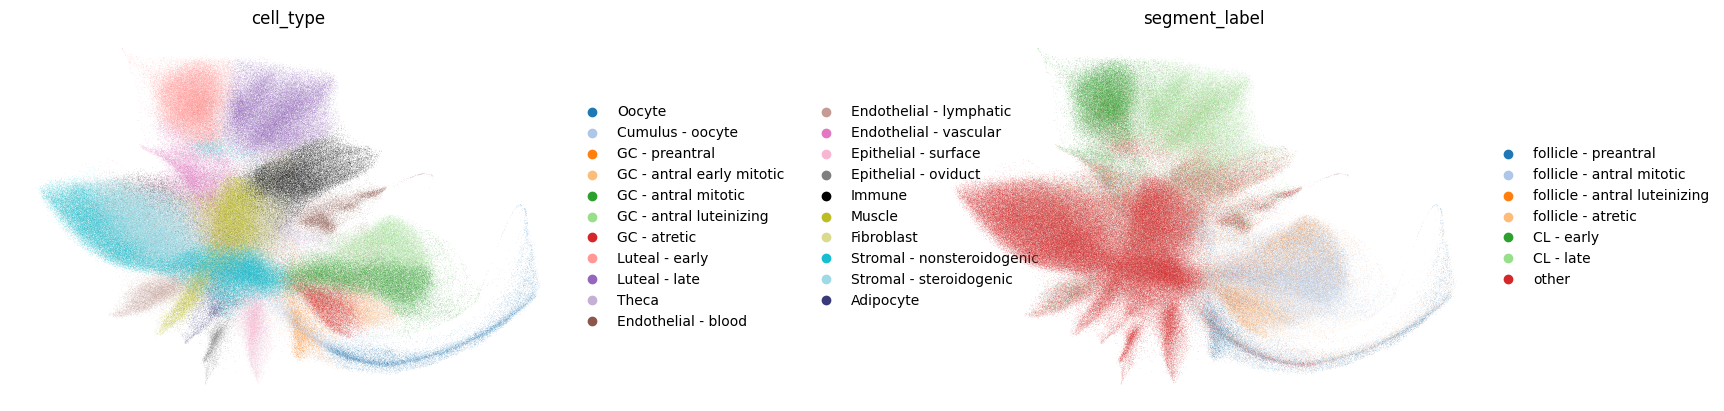

In [30]:
sc.pl.umap(adata, color=['cell_type', 'segment_label', ], #groups =['Oocyte - contaminated'],
           ncols = 3, vmax = 1,
           use_raw =False, wspace = 0.5, frameon=False, palette = custom_palette)

# DEG of follicles and CL

In [ ]:
#Cell types to exclude
cell_types_to_include = ['GC - preantral', 'GC - antral early mitotic', 'GC - antral mitotic', 
                         'GC - antral luteinizing', 'GC - atretic', 'Luteal - early', 'Luteal - late'
]

#Subset AnnData object to exclude the specified cell types
ad_sub = adata[adata.obs['cell_type'].isin(cell_types_to_include), :].copy()

# Plot the UMAP
sc.pl.umap(ad_sub, color=['cell_type', ])

In [45]:
#Cell types to include
cell_types_to_include = ['Young'
]

#Subset AnnData object to exclude the specified cell types
ad_sub_Y = ad_sub[ad_sub.obs['Age'].isin(cell_types_to_include), :].copy()

# Plot the UMAP
#sc.pl.umap(ad_sub_Y, color=['segment_label',])
#ad_sub_Y

In [46]:
#Cell types to include
cell_types_to_include = ['Old'
]

#Subset AnnData object to exclude the specified cell types
ad_sub_O = ad_sub[ad_sub.obs['Age'].isin(cell_types_to_include), :].copy()

# Plot the UMAP
#sc.pl.umap(ad_sub_O, color=['segment_label',])
#ad_sub_O

In [73]:
sc.pl.matrixplot(ad_sub_Y, ['Bmp15', 'Amhr2', 'Esr1', 'Esr2','Inhbb','Fshr', 'Fst', 
                    'Cyp17a1', 'Cyp19a1', 'Lhcgr', 'Parm1', 'Akr1c18'
],
                 groupby="cell_type", standard_scale = 'var', 
                 dendrogram = False, use_raw=True, swap_axes = False, color = 'Reds')